# We are running Grover Algorithm : The Algorithm the search the database through the Quantum Algorithm. 
It is really important to understand the Grover Algorithm first, which is mainly used to reduce the complexity of the Searching Algorithm. This is the explanation of using the Grover Algorithm : https://qiskit.org/textbook/ch-algorithms/grover.html

## README : 
1. Run All The Program, by clicking Cell --> Run All. Or you also able to click the shortcut **CTRL+F9**.
2. **Part 1** : Install the Library needed. Please bear in mind, if you have install this *qiskit*, *pylatexenc*, and *truth-table-generator*. You don't need to run this anymore.
3. After running all the program, in **Part 4** : *Truth Table section*, we need to identify :
   - Which qubits that you are searching
   - Truth Table rules
      * As discussed previously, we identify *1st argument : ~q* and *2nd argument : p xor q*. The table is illustrated as follows : 

| p | q | ~q  | p xor q  |   |
|---|---|-----|----------|---|
| 1 | 1 |  0  |     0    |   |
| 1 | 0 |  1  |     1    |   |
| 0 | 1 |  0  |     1    |   |
| 0 | 0 |  1  |     0    |   |


4. The Truth Table will be shown appropriately after choosing the desired rules of Truth Table
5. Run **Part 6 : Main Program**, and fill the iteration program for the simulation.  
6. You may see the result on the **7. Evaluation and Result** section.

## 1. Install Library needed
Please bear in mind, if you have install this qiskit, pylatexenc, and truth-table-generator. You don't need to run this anymore. 

In [2]:
# Run this if you haven't install qiskit, pylatexenc, and truth-table-generator
!pip install qiskit
!pip install qiskit --upgrade
!pip3 install pylatexenc
!pip install truth-table-generator

Requirement already up-to-date: qiskit in /usr/local/lib/python3.7/dist-packages (0.25.1)


## 2. Import all libraries

In [21]:
#initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer, QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.providers.ibmq import least_busy
from qiskit.quantum_info import Statevector

from qiskit.aqua.components import oracles

# import basic plot tools
from qiskit.visualization import plot_histogram

In [22]:
# Bold Color
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

## 3. Create Function Program needed

In [23]:
# Apply the H Gate
def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc

In [24]:
# Quantum 2 qubits
def list_qubit(n):
    list_measurement = []
    for i in range(n):
        list_measurement.append(i)
    return(list_measurement)

In [25]:
# Build the Oracle Function
def oracle(n_qubits, reversed_qubit):
    
    # Define the Quantum Circuit
    grover_circuit =  QuantumCircuit(3*n_qubits+1)
    
    # List Reversed
    list_reversed = list(range(n_qubits))
    list_reversed.reverse()

    print("Vous avez", n_qubits , "qubits")

    grover_circuit = initialize_s(grover_circuit, list(range(n_qubits)))
    
    # Build the Oracle 
    for i in range(n_qubits):
        grover_circuit.cx(i,i+n_qubits)

    # Cx Gate
    for i in range(n_qubits):
        grover_circuit.cx(i+n_qubits, i + (2*n_qubits))

    # X Gate
    list_new = []
    for j in range(2):
        for i in range(n_qubits+1):
            if(i == n_qubits):
                grover_circuit.h(i + (2*n_qubits))
            else:
                grover_circuit.x(i + (2*n_qubits))
        if(j != 1):
            for i in range((n_qubits)):
                list_new.append((2*n_qubits)+i)
            grover_circuit.mct(list_new,(3*n_qubits))

    # CX Gate
    for i in list_reversed:
        grover_circuit.cx(i+n_qubits,i + (2*n_qubits))

    # CX Gate
    for i in list_reversed:
        grover_circuit.cx(i, i + n_qubits)
        # We will return the diffuser as a gate
    U_s = grover_circuit.to_gate()
    U_s.name = "Oracle"
    return(U_s)

In [26]:
# Build the Diffuser Function
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "Diffuser"
    return(U_s)

In [27]:
# Build the Diffuser Function
def diffuser_un(nqubits):
    
    # Quantum Circuit A little bit
    qc = QuantumCircuit(nqubits)
    
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
        
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "Diffuser"
    return U_s

In [28]:
# Build the Statevector
def state_vector(circuit):
    sv_sim = Aer.get_backend('statevector_simulator')
    job_sim = execute(grover_circuit, sv_sim)
    statevec = job_sim.result().get_statevector()
    from qiskit_textbook.tools import vector2latex
    return vector2latex(statevec, pretext="|\\psi\\rangle =")

In [29]:
# Running the Program
def probabilities(grover_circuit):
    backend = Aer.get_backend('qasm_simulator')
    results = execute(grover_circuit, backend=backend, shots=1024).result()
    answer = results.get_counts()
    return(answer)

In [30]:
# Load IBM Q account and get the least busy backend device
def experiment_device(grover_circuit):
    provider = IBMQ.load_account()
    provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
    backend = provider.get_backend('ibmq_armonk')
    # Run our circuit on the least busy backend. Monitor the execution of the job in the queue
    from qiskit.tools.monitor import job_monitor
    job = execute(grover_circuit, backend=backend, shots=1024, optimization_level=3)
    job_monitor(job, interval = 2)

    # Get the results from the computation
    results = job.result()
    answer = results.get_counts(grover_circuit)
    plot_histogram(answer)

# 4. Create Function of Quantum -> Classical Gates


In [31]:
# AND Gate
# Position Argument : It depends on the argument of where you put in the Truth Table (1st, 2nd, 3rd)
def and_gate(n_qubits):
    # Define the Quantum Circuit
    qc = QuantumCircuit(n_qubits + 1)
    
    # Multi Controlled Toffoli Gate
    qc.mcx([0,1], n_qubits)
    
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "$AND Gate$"
    return(U_s)

In [32]:
# NAND Gate
# Position Argument : It depends on the argument of where you put in the Truth Table (1st, 2nd, 3rd)
def nand_gate(n_qubits):
    
    # Define the Quantum Circuit
    qc = QuantumCircuit(n_qubits + 1)
    
    # X-Gate NAND Gate
    for i in range(n_qubits+1):
        qc.x(i)
    
    # Multi Controlled Toffoli Gate
    qc.mcx([0,1], n_qubits)
    
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "$NAND Gate$"
    return(U_s)

In [33]:
# OR GATE
# Position Argument : It depends on the argument of where you put in the Truth Table (1st, 2nd, 3rd)
def or_gate(n_qubits):
    # Define the Quantum Circuit
    qc = QuantumCircuit(n_qubits + 1)
    
    # Range n_qubits
    for i in range(2):
        qc.x(i)
    
    # Besides of the Toffoli
    qc.x(n_qubits)
    
    # Multi Controlled Toffoli Gate
    qc.mcx([0,1], n_qubits)
    
    # We will return the OR as a gate
    U_s = qc.to_gate()
    U_s.name = "$OR GATE$"
    return(U_s)

In [34]:
# XOR Gate
# Position Argument : It depends on the XOR Gate
def xor_gate(n_qubits):
    
    # Define the Quantum Circuit
    qc = QuantumCircuit(n_qubits)
    
    # This is the CNOT Gate and X Gate
    qc.cx(0,1)
    
    # We will return the OR as a gate
    U_s = qc.to_gate()
    U_s.name = "$XOR GATE$"
    return(U_s)

In [35]:
# XnOR Gate
# Position Argument : It depends on the XOR Gate
def xnor_gate(n_qubits):
    
    # Define the Quantum Circuit
    qc = QuantumCircuit(n_qubits)
    
    # This is the CNOT Gate and X Gate
    qc.x(n_qubits-1)
    qc.cx(0,n_qubits-1)
    
    # We will return the OR as a gate
    U_s = qc.to_gate()
    U_s.name = "$XNOR GATE$"
    return(U_s)

In [36]:
# Implication Gate
def implies_gate(n_qubits):
    
    # Define the Quantum Circuit
    qc = QuantumCircuit(n_qubits+1)
    
    # This is the CNOT Gate and Toffoli Gate. 
    # The existing implies in here. 
    qc.x(n_qubits)
    qc.cx(0,1)
    qc.x(0)
    qc.mcx([0,1], n_qubits)
    
    # We will return the OR as a gate
    U_s = qc.to_gate()
    U_s.name = "$Implies GATE$"
    return(U_s)

In [37]:
# Special Gate
def special_gate(n_qubits):
    # Define the Quantum Circuit
    qc = QuantumCircuit(n_qubits+1)
    
    # This is the CNOT Gate and Toffoli Gate. 
    # The existing implies in here. 
    qc.x([0,1])
    qc.mcx([0,1], n_qubits)
    qc.cx(0,1)
    qc.cx(1,2)
    qc.mcx([0,1], n_qubits)
    
    # We will return the OR as a gate
    U_s = qc.to_gate()
    U_s.name = "$Special GATE$"
    return(U_s)

# 5. Choose Truth Table

In [38]:
import ttg
import pandas as pd

# For example 2 qubits
# ~q
# p xor q

statement = True
while(statement != False):
    # Define Variable
    list_calculation = []
    list_input = []
    iniput = ''
    output = ''

    # Defining how many qubits used for this gate
    print("How many qubits that you are looking?" + color.BOLD + " Par Exemple : 1 for 1 qubit, 2 for qubits, 3 for qubits" + color.END)
    print("----------------------------------------")
    n_qubits = int(input())
    print("----------------------------------------")

    # Rules of the Truth Table
    print(f"You have filled" + color.BOLD + f" {n_qubits} qubits," +color.END + " so you must filled" + color.BOLD + f" {n_qubits} argument" + color.END+ " as follows")
    # The Calculation qubits
    for i in range(n_qubits):
        print(f"The {i+1}-th Argument")
        print("----------------------")
        # String output
        string = input()
        list_calculation.append(string)

        # String input 
        inputan = chr(ord('p')+i)
        list_input.append(inputan)

    # Create the Table 
    table = ttg.Truths(list_input, list_calculation)
    table_pd = table.as_pandas()
    display(table_pd)

    # Inputan and Output
    for i in range(n_qubits):
        iniput  = iniput + " " + table_pd.iloc[:,i].astype(str) 
        output  = output + table_pd.iloc[:,i+n_qubits].astype(str)

    # Convert to the dataframe
    dataframe = pd.DataFrame({"input":iniput, 
                "output":output})

    # Check if there is any duplicates in the output (which is not correspond to what we want)
    statement = dataframe.output.duplicated().any()
    if(statement == True):
        print(color.RED + "Sorry, there is a duplicate output!" + color.END)
    # Successful 
print("Well done you have " + color.BLUE + "filled it correctly" + color.END)

How many qubits that you are looking? Par Exemple : 1 for 1 qubit, 2 for qubits, 3 for qubits
----------------------------------------
2
----------------------------------------
You have filled 2 qubits, so you must filled 2 argument as follows
The 1-th Argument
----------------------
~q
The 2-th Argument
----------------------
p xor q


,p,q,~q,p xor q
1,1,1,0,0
2,1,0,1,1
3,0,1,0,1
4,0,0,1,0


Well done you have filled it correctly


# 6. Main Program 


In [47]:
# Question remark of my qubits
print("--------------------------------------------------")
print("Quels qubits souhaitez-vous rechercher? " + color.BOLD + "Par Exemple : 0, 01, 101, 1100" + color.END)
qubit = input()
print("--------------------------------------------------")

# Argument
arg = 0
while arg !=1:
    if(len(qubit)!= n_qubits):
        print(color.RED + "Sorry, it's wrong!" + color.END + " Please put the same input with the " + color.BOLD + "total qubits before" + color.END)
        # Question remark of my qubits
        print("--------------------------------------------------")
        print("Quels qubits souhaitez-vous rechercher? " + color.BOLD + "Par Exemple : 0, 01, 101, 1100" + color.END)
        qubit = input()
        print("--------------------------------------------------")
        arg = 0
    else:
        print("Correct")
        print("--------------------------------------------------")
        arg = 1

--------------------------------------------------
Quels qubits souhaitez-vous rechercher? Par Exemple : 0, 01, 101, 1100
10
--------------------------------------------------
Correct
--------------------------------------------------


Vous Avez 2 qubits
How many interation do you want?
1
--------------------------------------------------


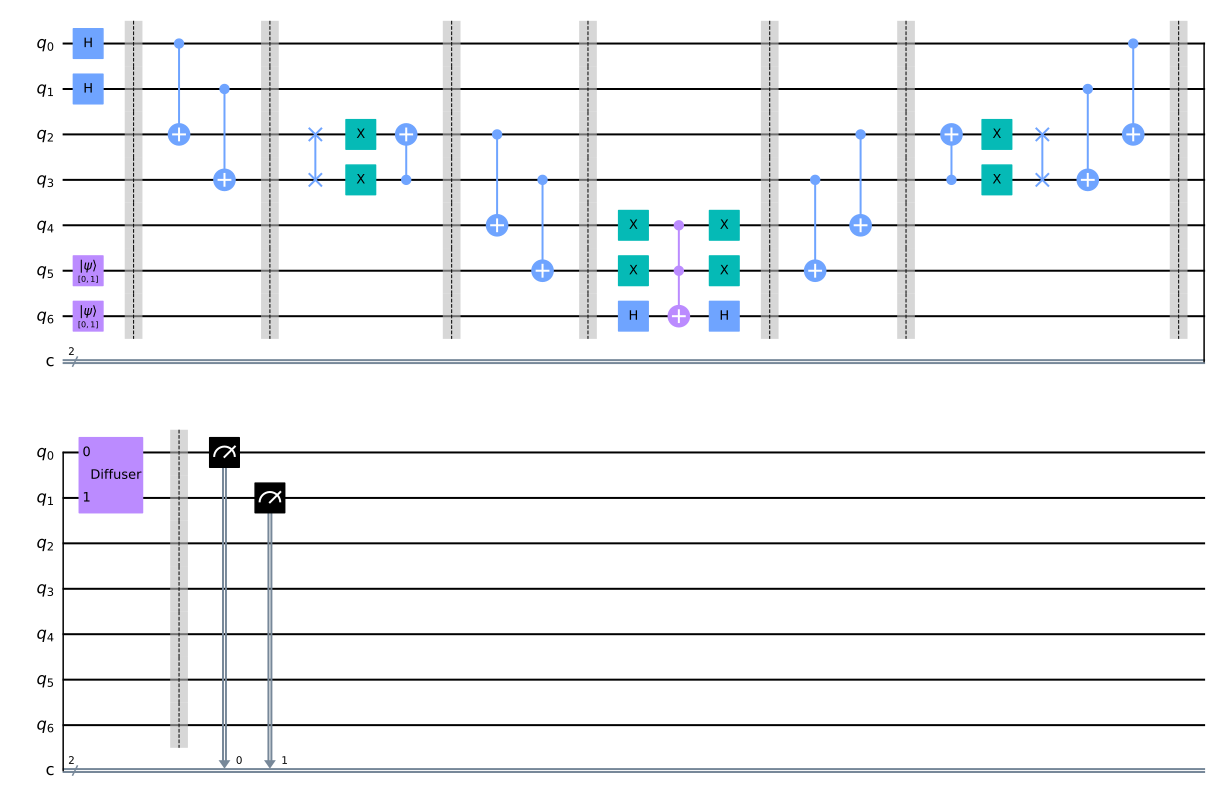

In [48]:
# Analysis the input qubit
# Initialize to 1
# %config InlineBackend.figure_format = 'svg' # Makes the images fit
initial_state = [0,1]
analyse_iteration = []

# Reversing the Qubit Information
reversed_qubit = qubit[::-1]

# Initialize the Quantum Circuit
if(n_qubits != 1):
    grover_circuit = QuantumCircuit((3*(n_qubits)) + 1, n_qubits)
else:
    grover_circuit = QuantumCircuit((3*(n_qubits)) + 2, n_qubits)

# List Reversed
if(n_qubits !=1):
    list_reversed = list(range(n_qubits))
    list_reversed.reverse()
else:
    list_reversed = list(range(n_qubits+2))
    list_reversed.reverse()
    
# Define the classical bits
cbit = n_qubits 
print("Vous Avez", n_qubits , "qubits")

# Initialize the Quantum Circuit (How much the total qubits + ancilla qubits needed)
grover_circuit = initialize_s(grover_circuit, list(range(n_qubits)))

# Iteration
print("How many interation do you want?")
iteration = int(input())
print("--------------------------------------------------")

# Desired Value ->(&)
for i,j in enumerate(reversed_qubit):
    if(n_qubits != 1): # If n_qubits is not equal to 1
        if(int(j) == 1):
            grover_circuit.initialize(initial_state, int(i) + (3*(n_qubits))-2)
    else: # If equal to 1
        if(int(j) == 1):
            grover_circuit.initialize(initial_state, int(i) + (3*(n_qubits))-1)

# All the Circuits            
for i in range(iteration):
    if(n_qubits != 1):
        # Initialize the Hadamard on the last
        grover_circuit.initialize(initial_state, (3*(n_qubits)))
        grover_circuit.barrier()

        # Build the Flip Gate for Truth Table. Tres IMPORTANT !!
        for i in range(n_qubits):
            grover_circuit.cx(i, i + n_qubits)
        grover_circuit.barrier()
        
        #### C'est un important -> Truth Table Gate         
        # # X Gate aja
        grover_circuit.swap(2,3)
        grover_circuit.x([2,3])
        grover_circuit.cx(3,2)
        
        # This is swapping gates (It should be on the above)
        grover_circuit.barrier()

        # CX Gate
        for i in range(n_qubits):
            grover_circuit.cx(i+n_qubits, i + (2*n_qubits))
        grover_circuit.barrier()

        # X Gate
        list_new = []
        for j in range(2):
            for i in range(n_qubits+1):
                if(i == n_qubits):
                    grover_circuit.h(i + (2*n_qubits))
                else:
                    grover_circuit.x(i + (2*n_qubits))
            if(j != 1):
                for i in range((n_qubits)):
                    list_new.append((2*n_qubits)+i)
                grover_circuit.mct(list_new,(3*n_qubits))
        
        grover_circuit.barrier()

        # CX Gate
        for i in list_reversed:
            grover_circuit.cx(i+n_qubits,i + (2*n_qubits))
        grover_circuit.barrier()
        
        # # # CNOT Gate
        grover_circuit.cx(3,2)
        grover_circuit.x([2,3])
        grover_circuit.swap(2,3)
        
        # Last Oracle
        for i in list_reversed:
            grover_circuit.cx(i, i + n_qubits)
        grover_circuit.barrier()

        # Diffusion
        grover_circuit.append(diffuser(n_qubits), list(range(n_qubits)))
        grover_circuit.barrier()
    
        # # Result Oriented
        # result_2 = probabilities(grover_circuit)

        # analyse_iteration.append(result_2[qubit])
    # If there is a Single Qubit over it
    else:
        # Initialize the Hazamard on the last
        grover_circuit.initialize(initial_state, (3*(n_qubits))+1)
        
        grover_circuit.barrier()
        # Build the Oracle 
        for i in range(n_qubits+2):
            grover_circuit.cx(i,i+n_qubits)
        grover_circuit.barrier()

        # X Gate 
        list_new = []
        for j in range(2):
            for i in range(n_qubits+2):
                if(i == n_qubits+1):
                    grover_circuit.h(i + (2*n_qubits))
                else:
                    grover_circuit.x(i + (2*n_qubits))
            if(j != 1):
                for i in range((n_qubits)+1):
                    list_new.append((2*n_qubits)+i)
                grover_circuit.mct(list_new,(3*n_qubits)+1)
        grover_circuit.barrier()
        
        # Last Oracle
        for i in list_reversed:
            grover_circuit.cx(i, i + n_qubits)
        grover_circuit.barrier()
        
        # Grover Diffuser Un
        grover_circuit.append(diffuser_un(n_qubits), list(range(n_qubits)))
      
# Measurement
grover_circuit.measure(list(range(n_qubits)),list(range(n_qubits)))
grover_circuit.draw(output = 'mpl')

Simulation Result


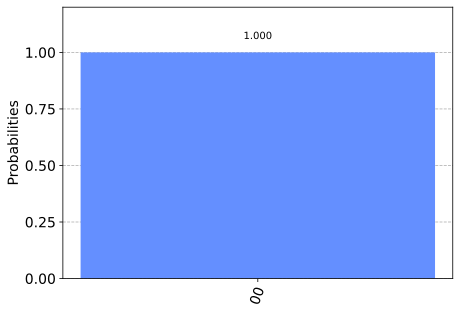

In [49]:
# Explorez le Probabilities
%config InlineBackend.figure_format = 'svg' # Makes the images fit
result_2 = probabilities(grover_circuit)
print("Simulation Result")
plot_histogram(result_2)